In [1]:
import json
import os
import cv2
from torch.utils.data import random_split, DataLoader

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.draw import ellipse
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
class CorneaUlcerDataset(Dataset):
    def __init__(self, json_file, image_dir, transform=None, target_size=(256, 256)):
        with open(json_file, "r") as f:
            self.data = json.load(f)
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        image_name = entry["file_upload"].split("-")[-1]
        img_path = os.path.join(self.image_dir, image_name)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        annotations = entry["annotations"][0]["result"]

        # Loop over results to find "Córnea" and "Úlcera"
        cornea_ellipse = None
        ulcer_polygon = None
        for result in annotations:
            if result["from_name"] == "cornea":
                cornea_ellipse = result["value"]
            elif result["from_name"] == "ulcer":
                ulcer_polygon = result["value"]["points"]

        # Crop Image based on ellipse
        if cornea_ellipse:
            x_center = int(cornea_ellipse["x"] / 100 * image.shape[1])
            y_center = int(cornea_ellipse["y"] / 100 * image.shape[0])
            radius_x = int(cornea_ellipse["radiusX"] / 100 * image.shape[1])
            radius_y = int(cornea_ellipse["radiusY"] / 100 * image.shape[0])

            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            rr, cc = ellipse(y_center, x_center, radius_y, radius_x)
            mask[rr, cc] = 255
            cropped_image = cv2.bitwise_and(image, image, mask=mask)
        else:
            cropped_image = image

        # Resize cropped image to target size
        cropped_image = cv2.resize(
            cropped_image, self.target_size, interpolation=cv2.INTER_AREA
        )

        # Create binary mask from polygon (if available) -> NOT ALL
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        if ulcer_polygon:
            points = [
                (int(x / 100 * image.shape[1]), int(y / 100 * image.shape[0]))
                for x, y in ulcer_polygon
            ]
            points = np.array([points], dtype=np.int32)
            cv2.fillPoly(mask, points, 255)

        # Resize mask to target size
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # Convert cropped image and mask to PIL images for transformations
        cropped_image = Image.fromarray(cropped_image)
        mask = Image.fromarray(mask)

        # Apply transformations if provided
        if self.transform:
            cropped_image = self.transform(cropped_image)
            mask = self.transform(mask)

        return cropped_image, mask, image_name

In [3]:
def load_data(json_path, img_dir, batch_size=8):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((256, 256))]
    )
    dataset = CorneaUlcerDataset(json_path, img_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
def train_model(model, device, dataloader, num_epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks, _ in dataloader:
            # Move data to device -> TESTED IN M3
            images, masks = images.to(device), masks.to(device)

            images = images.float()
            masks = masks.float()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

In [5]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, feature_base=64):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(in_channels, feature_base)
        self.encoder2 = self.conv_block(feature_base, feature_base * 2)
        self.encoder3 = self.conv_block(feature_base * 2, feature_base * 4)
        self.encoder4 = self.conv_block(feature_base * 4, feature_base * 8)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by a factor of 2

        # Bottleneck
        self.bottleneck = self.conv_block(feature_base * 8, feature_base * 16)

        self.upconv4 = nn.ConvTranspose2d(
            feature_base * 16, feature_base * 8, kernel_size=2, stride=2
        )
        self.decoder4 = self.conv_block(feature_base * 16, feature_base * 8)

        self.upconv3 = nn.ConvTranspose2d(
            feature_base * 8, feature_base * 4, kernel_size=2, stride=2
        )
        self.decoder3 = self.conv_block(feature_base * 8, feature_base * 4)

        self.upconv2 = nn.ConvTranspose2d(
            feature_base * 4, feature_base * 2, kernel_size=2, stride=2
        )
        self.decoder2 = self.conv_block(feature_base * 4, feature_base * 2)

        self.upconv1 = nn.ConvTranspose2d(
            feature_base * 2, feature_base, kernel_size=2, stride=2
        )
        self.decoder1 = self.conv_block(feature_base * 2, feature_base)

        # Final Convolution
        self.final_conv = nn.Conv2d(feature_base, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.pool(x1)
        x3 = self.encoder2(x2)
        x4 = self.pool(x3)
        x5 = self.encoder3(x4)
        x6 = self.pool(x5)
        x7 = self.encoder4(x6)
        x8 = self.pool(x7)

        # Bottleneck
        bottleneck = self.bottleneck(x8)

        # Decoder with skip connections
        d4 = self.upconv4(bottleneck)
        d4 = torch.cat((d4, x7), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, x5), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, x3), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, x1), dim=1)
        d1 = self.decoder1(d1)
        # Sigmoid for binary segmentation
        return torch.sigmoid(self.final_conv(d1))

In [6]:
def create_dataloaders(json_path, img_dir, batch_size=8, train_ratio=0.8):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Resize((256, 256))]
    )

    # Load the full dataset
    dataset = CorneaUlcerDataset(json_path, img_dir, transform=transform)

    # Split the dataset
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [7]:
import torch

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    mps_device = torch.device("cpu")


json_path = "../data/image_anotations.json"
img_dir = "../data/raw"
train_loader, test_loader = create_dataloaders(json_path, img_dir, batch_size=4)


model = UNet().to(mps_device)
train_model(model, device=mps_device, dataloader=train_loader, num_epochs=10, lr=0.01)

tensor([1.], device='mps:0')
Epoch [1/10], Loss: 0.10958966589532793
Epoch [2/10], Loss: 0.04337814117951149
Epoch [3/10], Loss: 0.04329120998524807
Epoch [4/10], Loss: 0.041746567617255176
Epoch [5/10], Loss: 0.044129667433232746
Epoch [6/10], Loss: 0.03845507600768046
Epoch [7/10], Loss: 0.037189662604677404
Epoch [8/10], Loss: 0.03662729953331026
Epoch [9/10], Loss: 0.03848782444203442
Epoch [10/10], Loss: 0.03937712820797143


In [14]:
# %%
def visualize_results(model, device, dataloader, num_samples=5):
    model.eval()  # Set model to evaluation mode
    model.to(device)

    with torch.no_grad():  # Disable gradient calculation for faster inference
        for i, (images, masks, image_names) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            # Generate predictions
            predictions = model(images)
            predictions = torch.sigmoid(predictions)

            images = images.cpu().numpy()
            masks = masks.cpu().numpy()
            predictions = predictions.cpu().numpy()

            # Plot each sample in the batch
            for j in range(min(num_samples, images.shape[0])):
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                fig.suptitle(f"Image name {image_names[j]}")

                # Original image
                original_image = images[j].transpose(1, 2, 0)
                axes[0].imshow(original_image)
                axes[0].set_title("Original Image")
                axes[0].axis("off")

                # Ground truth mask
                gt_mask = masks[j][0]
                axes[1].imshow(original_image)
                axes[1].imshow(gt_mask, cmap="jet", alpha=0.5)
                axes[1].set_title("Ground Truth Mask Overlay")
                axes[1].axis("off")

                # Predicted mask
                pred_mask = predictions[j][0]
                axes[2].imshow(original_image)
                axes[2].imshow(pred_mask, cmap="jet", alpha=0.5)
                axes[2].set_title("Predicted Mask Overlay")
                axes[2].axis("off")

                plt.title("")
                plt.show()

            if i * dataloader.batch_size >= num_samples:
                break

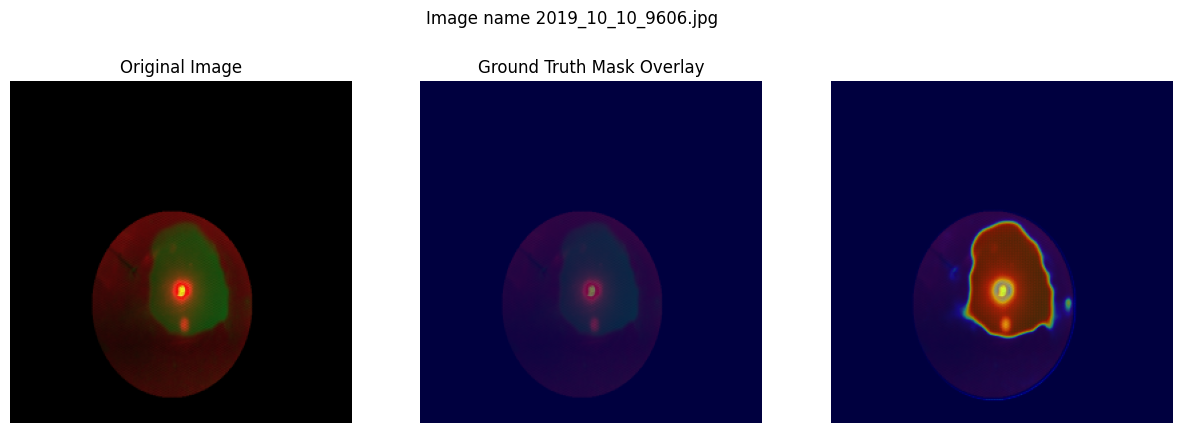

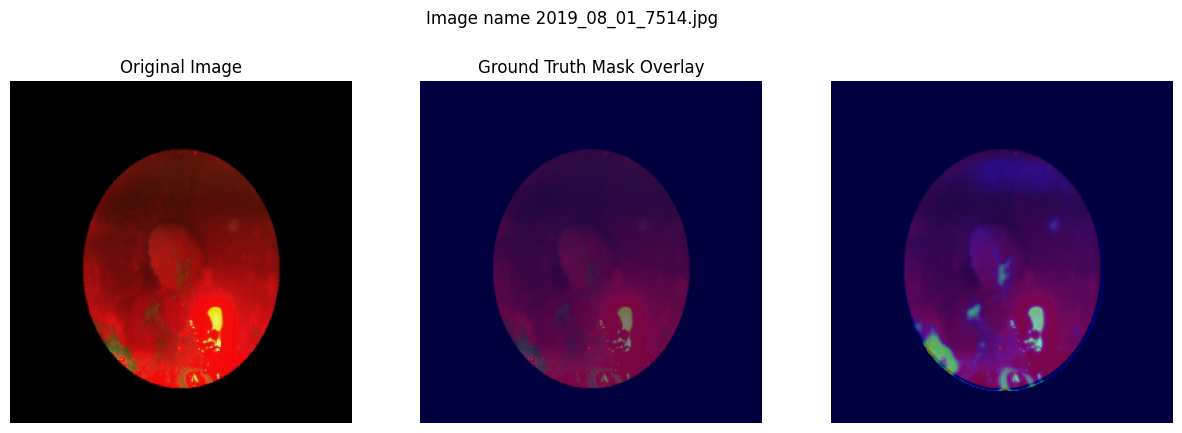

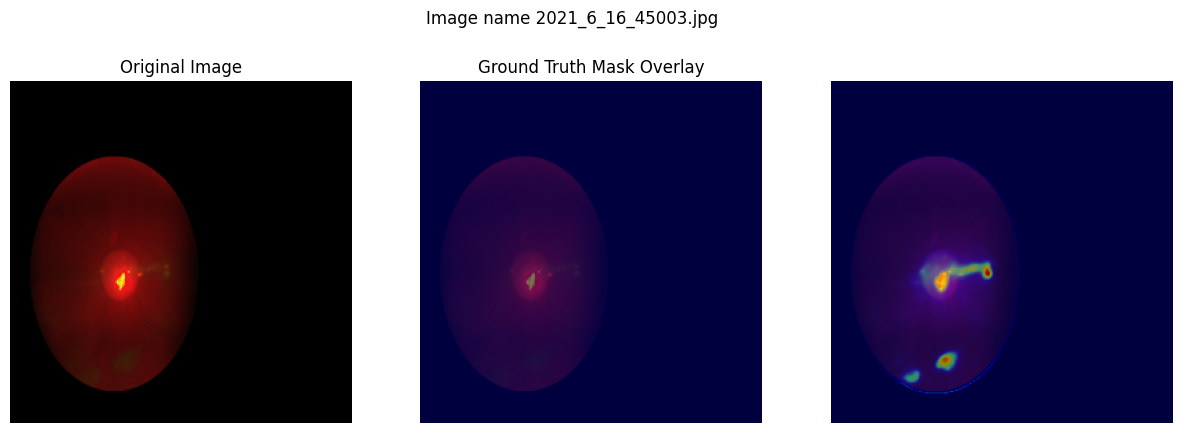

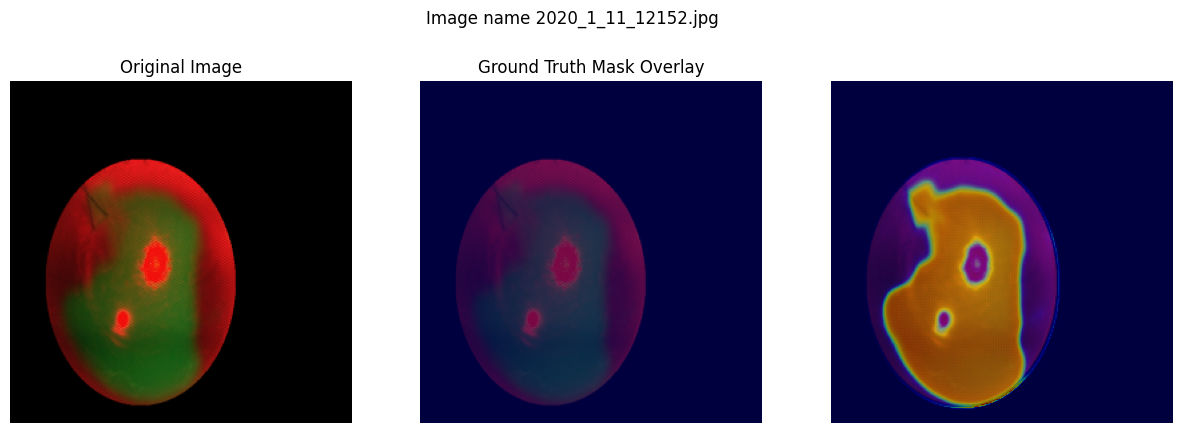

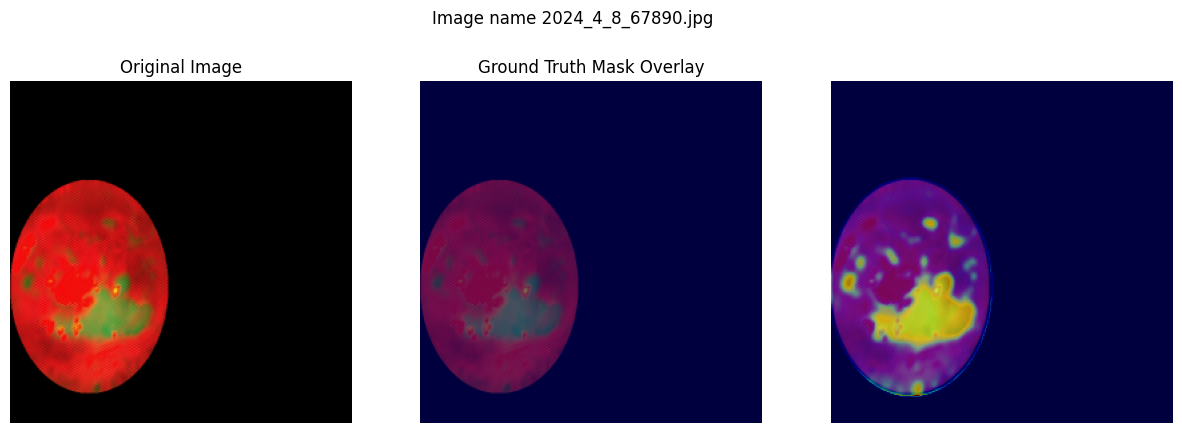

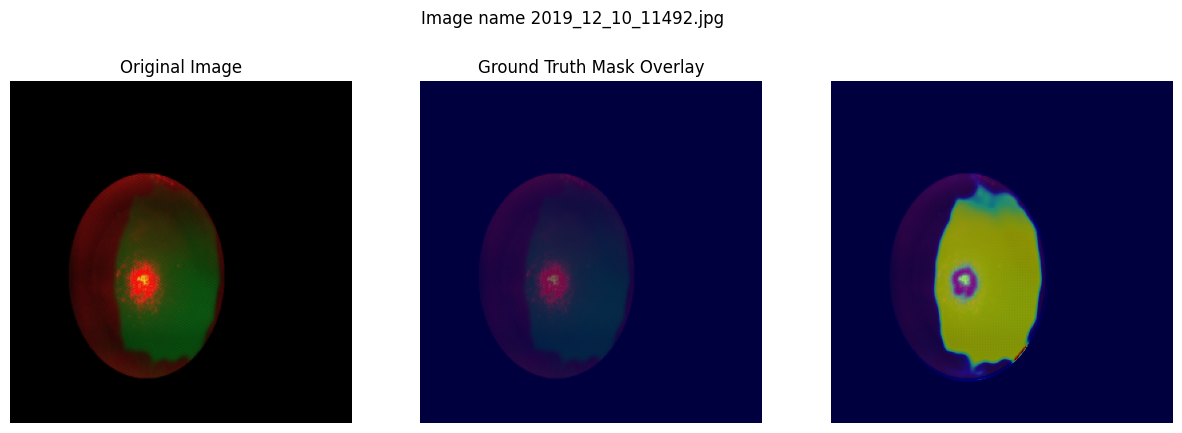

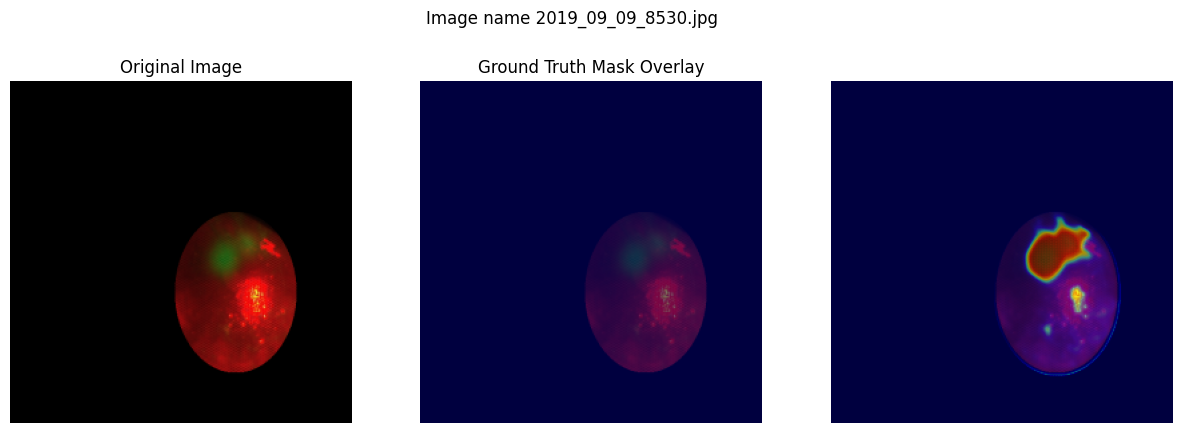

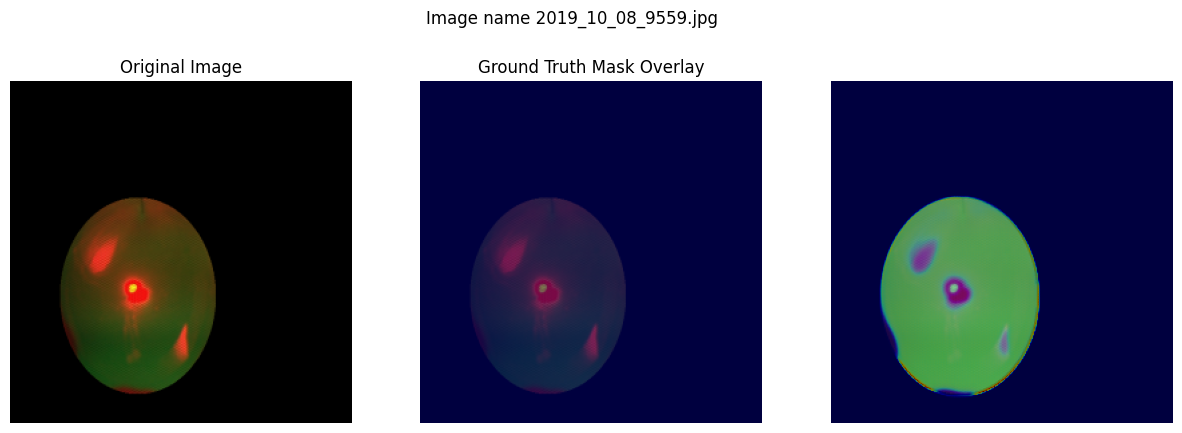

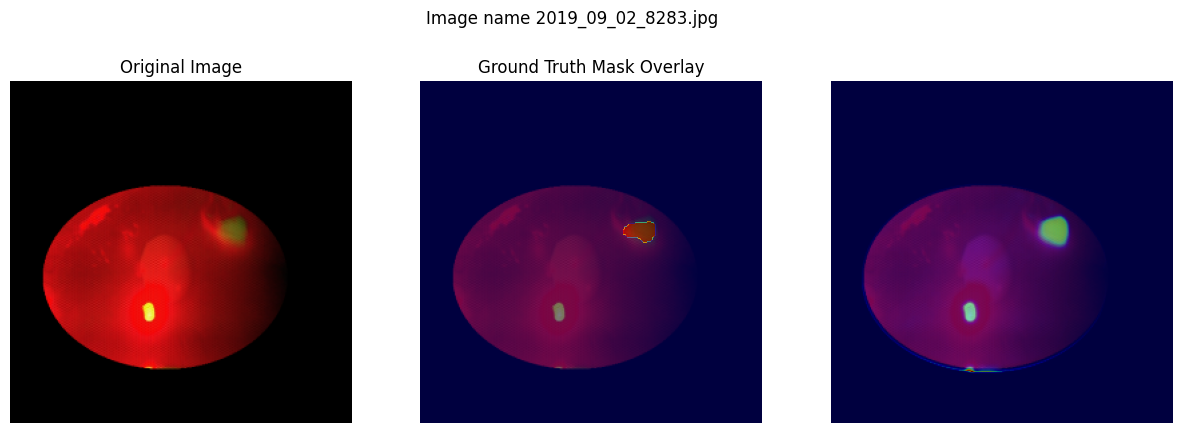

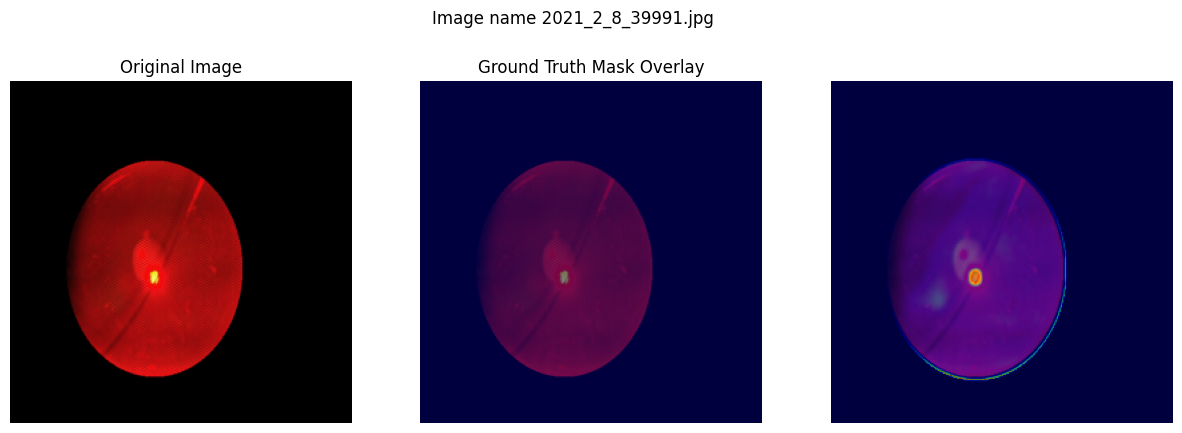

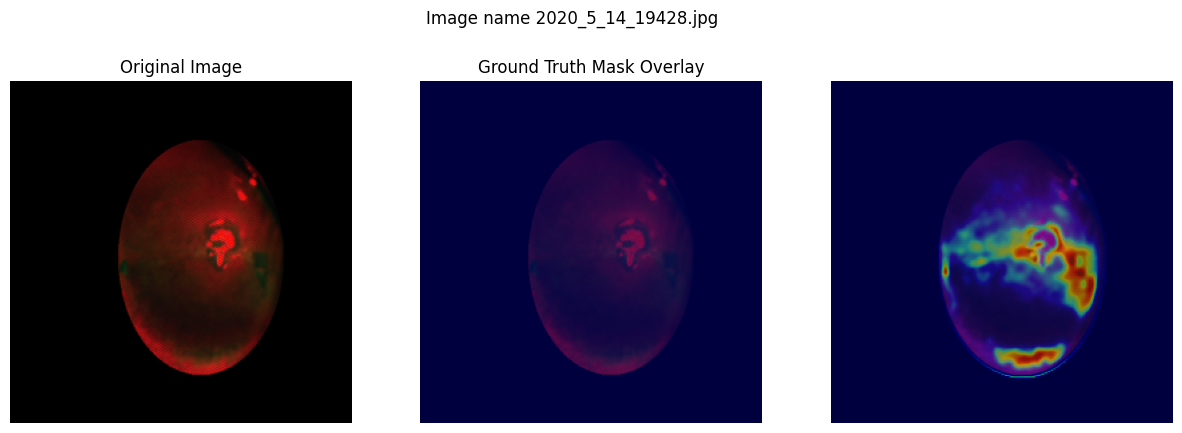

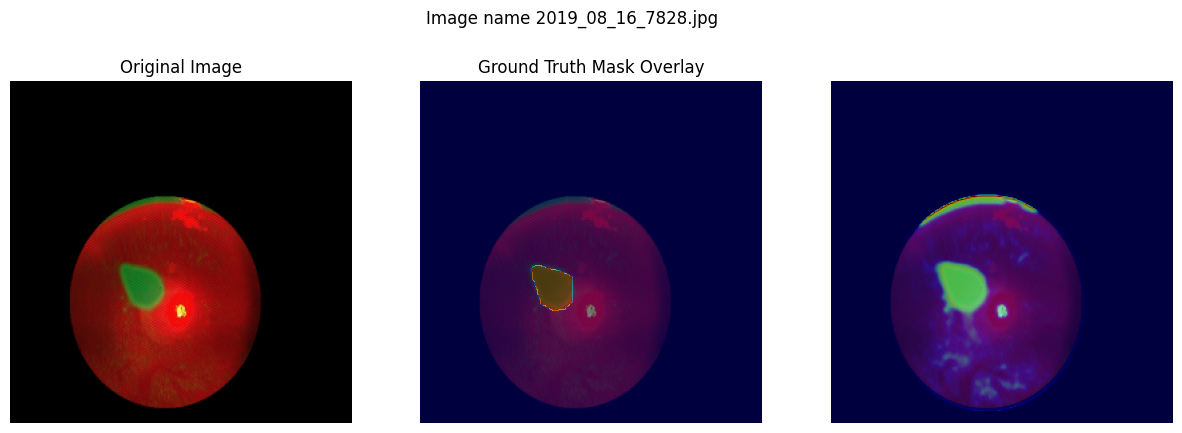

In [15]:
visualize_results(model, dataloader=test_loader, device=mps_device, num_samples=5)

# Conclusiones

Durante esta fase del proyecto, nos enfocamos en la creación de máscaras tanto para córneas como para úlceras con el fin de evaluar el desempeño del modelo en la segmentación con los datos disponibles. Un aspecto importante fue el procesamiento de las anotaciones en formato JSON, las cuales contenían imágenes tanto con como sin máscara. Esto nos llevó a considerar la posibilidad de desarrollar un flujo adicional de preprocesamiento para filtrar o procesar las imágenes adecuadamente según sus etiquetas de máscara.

Los primeros resultados en el conjunto de datos de prueba mostraron un desempeño de segmentación prometedor, logrando detecciones satisfactorias incluso con solo 50 imágenes etiquetadas. Estos resultados iniciales superaron nuestras expectativas, demostrando el potencial del modelo para identificar úlceras en imágenes no etiquetadas.

Los próximos pasos incluyen finalizar el proceso de creación de máscaras, así como limpiar y estructurar el JSON para obtener mediciones concluyentes. Además, continuaremos optimizando la base de datos y enfocándonos en mejorar las métricas de rendimiento del modelo. Esto nos permitirá evaluar cuantitativamente la precisión de nuestro enfoque y compararlo con los modelos del estudio original.
